# Intro and Install Instructions

Quantum Toolbox in Python ([QuTiP](https://qutip.org/)) is an open-source software package useful for simulation a variety of quantum systems. Although it is well-documented online, it has many applications and can quickly turn into a deep rabbit hole if one isn't careful. In order to have a more directed focus, I attempt to give a brief introduciton as it applies to simulating quantum optical systems. To begin, it will be necessary to install Python locally along with the QuTiP libraries. I suggest [installing Anaconda](https://docs.anaconda.com/anaconda/install/index.html) and using [Jupyter Notebooks](https://jupyter.org/) with [Anaconda Navigator](https://docs.anaconda.com/anaconda/navigator/index.html). Using Jupyter Notebooks allows for one to easily interact with the code and quickly edit and replot different segments. 

After installing Anaconda, run the Anaconda Prompt to lauch a terminal. Next, if desired, create an environment for QuTiP using 'conda create --name myenv' where 'myenv' is the environment name. Activate this environment with 'conda activate myenv'. Once one has an Anaconda environment active (or simply in the base environment), one can install QuTip with pip using the command 'pip install qutip'. Install Anaconda navigator with 'conda install anaconda-navigator'. After the install, launch Anaconda Navigator, and then Jupyter Notebook can be installed using the user interface. Alternatively, it can be installed via the terminal.

Because the quantized electromagnetic field can be described as a quantum harmonic oscillator as discussed briefly in Thesis Chapter 1, any quantum-optical mode (qumode) can be written in the Fock basis and described in terms of eigenstates of the harmonic oscillator. This is ammenable to computation with linear algebraic computing methods since all states can be represented by a discrete basis. Additionally, nearly all physical quantum states can be accurately described with a finite-dimensional Hilbert space - we impose an energy cutoff that limits the maximum Fock-basis component. This is equivalent to saying that the probability to find any number of photons above some maximum value in a given quantum state vanishes.

Of course, states in real life can have many orders of magnitude of photons. However, if a system has $N$ photons, then quantum effects generally only persist if the losses are on the order of $\tfrac{1}{N}$ or lower (see the Thesis Chapter on Quantum Sensing). Thus, for quantum effects, a realistic Hilbert space for a single qumode is generally not too large. However, the Hilbert space scales exponentially when considering multiply qumodes. The point of quantum computing is to take advantage of this exponential scaling, so obviously it will be difficult to simulate classically, but the point here is that the Hilbert space scales as $d^n$ where $d$ is the Hilbert space dimension of a single mode and $n$ is the number of modes. With qumodes, the base itself, $d$, can be quite large, which leads to running into a classical wall much faster than with qubits. 

For example, supposed I have a computer with 16 GB of memory which is $\sim\!1.3\times10^{11}$ bits. To perform one simple simulation, the computer will at minimum have to hold one matrix describing the state, one matrix describing the operator to be applied, and one matrix describing the output state. This is even very optimistic, as I am ignorning any intermediate memory needed to calculate floating-point operations of the matrix multiplication. Regardless, for a Hilber space of $D=d^n$, the state will have $\sim 2D$ real parameters (since probability amplitudes can be complex), and the operator will need memory allocation for $\sim\!(2D)^2$ parameters. If each parameter is a float data type containing 32 bits, then to simulate this simple evolution we need $32\times(4D+4D^2)$ bits of memory at minimum. This leads to a maximum total Hilbert space of $D\approx 32,000$, which means one could not quite simulate 15 qubits. However, for an optical system with $1\%$ overall loss, which is not unreasonable experimentally, one could have up to $N\approx100$ photons in an optical mode with quantum effects. Setting $d=100$ means we can only simulate 2 qumodes with the same 16 GB machine! This, again, is the power of continuous-variable quantum optics we would like to leverage.

I digress - back to simulating quantum optics. The first order of business is to understand how quantum optical states can be represented in a way that a machine could easily perform calculations. The natural way is already prescribed by linear algebra. We simply assign each state a complex vector that gives the Fock-basis representation. As an example, the single-mode Fock state $|n\rangle$ can be described by the unit vector $(0,0,...,1,...,0)$, where the 1 is located in the $n$-th possition of the $d$-dimensional vector. Similarly, operators are represented by $d^2$-dimensional square matrices. Multi-mode states and operators are just created by taking the tensor product between single-mode state vectors and operator matrices, respectively. This will become more clear with some examples, so let's start by importing some other Python packages used for mathematics and plotting, and they we'll import everything from qutip. Generally, it saves memory and computation time by only importing specific functions from the QuTip library, but for now, we won't worry about that and will just import everything.

# Basics

In [1]:
import numpy as np
import  matplotlib.pyplot as plt
import math, cmath, random, functools, scipy
from qutip import*


Let's start by defining a small Hilbert space, just large enough to see what's going on without become overly cumbersome. We'll then define the bosonic annihilation operator, $\hat{a}$, along with a single photon Fock state, $|1\rangle$.

In [2]:
Dim=4 #Define the Hilbert Space dimension
a1=destroy(Dim) #the single-mode annihilation operator
photon=fock(Dim,1) # a Fock state existing in Hilbert space size Dim with excitation 1

Start by looking at exactly what the variable 'photon' is. Notice that in addition to being a vector, the QuTiP library makes it a Quantum object from the class Qobj(), which has several useful features in addition to keeping track of the quantum properties (such as being a bra or ket).

In [3]:
photon

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

The above vector is a ket, but we can get the bra by taking the dagger of the quantum object. In fact, the .dag() method can be applied to any quantum object to get the daggered state or operator.

In [4]:
photon.dag()

Quantum object: dims = [[1], [4]], shape = (1, 4), type = bra
Qobj data =
[[0. 1. 0. 0.]]

Note that instead of using the fock() function, we could also define an array and later pass it to the Qobj() class. This is a useful way to initialize any input state vector. The .full() method converts a quantum object back to an array. 

In [5]:
my_array=np.array([0,1,0,0])
print('To a quantum object: ', Qobj(my_array))
print('And back to an array... ',Qobj(my_array).full())

To a quantum object:  Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]
And back to an array...  [[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]


I can also use the .norm() method to find the norm of any vector. In this way I can normalize an otherwise non-normalized state. I can also use the .unit() method to turn any vector into a unit vector. Suppose I want to input the superposition $\tfrac{1}{\sqrt{2}}(|1\rangle+|2\rangle)$ but am lazy and neglect the normalizing factor.

In [6]:
my_array=np.array([0,1,1,0])
superpos=Qobj(my_array)
normed_superpos=superpos.unit()
normed_superpos

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]

Next, let's look at an operator, the annihilation operator defined above.

In [7]:
a1

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         1.         0.         0.        ]
 [0.         0.         1.41421356 0.        ]
 [0.         0.         0.         1.73205081]
 [0.         0.         0.         0.        ]]

The annihilation operator is define such that it will map every $n$ Fock state to the $n-1$ Fock state along with the necessary coefficients as expected: $\hat{a}|n\rangle=\sqrt{n}|n-1\rangle$. Similarly, one can use the creation operator simply by taking the dagger of annihilation operator. Let's apply $\hat{a}^{\dagger 2}$ to the vacuum to generate the two-photon Fock state.

In [8]:
vac=fock(Dim,0)
two_photon=(a1.dag()**2*vac).unit()
two_photon

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

Superpositions can be defined by turning an array into a quantum object, but they can also be formed by summing Fock states. For example, lets make the state $|\psi\rangle=\tfrac{1}{\sqrt{2}}(|0\rangle+i|2\rangle)$.

In [9]:
superpos2=(fock(Dim,0)+1j*fock(Dim,2)).unit()
superpos2

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        +0.j        ]
 [0.        +0.70710678j]
 [0.        +0.j        ]]

Because all real quantum state simulations will need to include imperfects such as loss, we need a way to deal with mixtures. Fortunately, density matrices are equally easy to deal with. However, note that the density matrix takes up more memory and thus takes longer to perform calculations with since the computer needs to put a complex number at each element in the square matrix. We can get the density matrix in two ways: either use the ket2dm() function or take a product of the ket and the bra. We can check that the two density matrices are the same by using the fidelity() function.

In [10]:
dm1=ket2dm(superpos2)
dm2=superpos2*superpos2.dag()
print(dm1)
print('The fidelity is: ', fidelity(dm1,dm2)**2)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.5j 0. +0.j  0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]
The fidelity is:  1.0000000149011607


The fidelity is 1, so they are the same state. The fractial deviations are due to round-off errors when using the built in functions and a finite Hilbert space. Generally, numerical calculations aren't reliable beyond the fourth or fifth decimal. Note that this fidelity function returns $$\text{Tr}\left[\sqrt{\sqrt{\sigma}\rho\sqrt{\sigma}}\right]$$ ($\text{Tr}\left[\sqrt{\sigma\rho}\right]$ if either state is pure), so we also need to square it to get the regular definition. Without squaring, we get the overlap of the absolute value of the probability amplitudes, but because we want to know how close two states are, comaring probabilites makes more sense. This is clearer if we take the state dm1 which is an even superposition of $|0\rangle$ and $|2\rangle$, so we would expect the fidelity with either consistuent part to be $1/2$ and not $\tfrac{1}{\sqrt{2}}$.

In [11]:
print('Without squaring: ',fidelity(dm1,fock(Dim,2)))
print('With squaring: ', fidelity(dm1,fock(Dim,2))**2)

Without squaring:  0.7071067811865475
With squaring:  0.4999999999999999


Now, let's try to calculate some expectation values. For a given operator $\hat{O}$, this can be done either as $\langle \psi|\hat{O}|\psi\rangle$ or by taking the trace $\text{Tr}[\rho\hat{O}]$. Let's do the expectation of photon number, $\langle \hat{a}^\dagger \hat{a}\rangle$. Notice that while the answer is the same, the data type isn't. Using the latter method of the trace, we just get a number. Using the former, however, we get a $1\times1$ quantum object. 

In [12]:
print(superpos2.dag()*a1.dag()*a1*superpos2)
print((dm1*a1.dag()*a1).tr())

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[1.]]
1.0


Occassionally it is useful to time code segments, as occassionally diffect methods achieving the same calculation may take different times. In general, if one can perform a calculation with pure state, it is generally easier (faster or less memory) to perform calculations without density matrices. Of course, if one later wishes to introduce loss, the density matrix formalism will become necessary.

In [13]:
Q=(1/np.sqrt(2))*(a1.dag()+a1)
import time
t1=time.time()
var=(dm1*Q**2).tr()-(dm1*Q).tr()**2
t2=time.time()
print('Variance of Q is ', var, ' and took ', t2-t1)

Variance of Q is  1.4999999999999996  and took  0.0009970664978027344


Next, consider how we treat multi-mode systems. If one has two qumodes, $|\psi\rangle|\phi\rangle$, this state can be encode by taking the tensor product of the two. Similarly, I could make a two mode operator out of a tensor product of two single-mode operators. Remember that taking a tensor product is essentially how the Hilbert spaces merge, so we always have to be careful to make the dimensions of everything match.

As an example, let's take $|\psi\rangle=|0\rangle$ and $|\phi\rangle=\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. Now, apply the creation operator to just the first mode to add in one photon, and calculate the mean photon number, which can be done on the individual mode separately and then later add the result, so the tensor products aren't really necessary. Next, apply a superposition of a creation operator to each mode: $\tfrac{1}{\sqrt{2}}(\hat{a}_1^\dagger+\hat{a}_2^\dagger)$. Now taking the tensor products is absolutely necessaray. One might naively think that the expectation of final photon number will be the same in both cases, but since $\hat{a}^\dagger|n\rangle=\sqrt{n+1}|n+1\rangle$, the coefficient will change the ratio of the compenents of the superpostion. Thus, applying creation operators is not the same as 'adding' a photon. Note that qeye($Dim$) is the identity matrix as a quantum object for a $Dim$ dimensional Hilbert space. I'll also reduce the size of the Hilbert space for easier visualization, and define an annihilation operator for each mode. This isn't strictly necessary, but it is helpful as a bookkeeping method.

In [14]:
Dim=3; a1=destroy(Dim); a2=destroy(Dim) 
psi=fock(Dim,1)
phi=(fock(Dim,0)+fock(Dim,1)).unit()
in_state=tensor(psi,phi)
print('The initial state is, ', in_state)
out1=(tensor(a1.dag(),qeye(Dim))*in_state).unit()
print()
print('Applying the creation operator to the first mode and normalizing yields ', out1)
exp1=out1.dag()*(tensor(a1.dag()*a1,qeye(Dim))+tensor(qeye(Dim),a2.dag()*a2))*out1
print('Which has photon-number expectation value of ', exp1)
out2=((tensor(a1.dag(),qeye(Dim))+tensor(qeye(Dim),a2.dag()))*in_state).unit()
print('Applying a superposition of creation operators to both modes and normalizing yields ', out2)
exp2=out2.dag()*(tensor(a1.dag()*a1,qeye(Dim))+tensor(qeye(Dim),a2.dag()*a2))*out2
print('Which has photon-number expectation value of ', exp2)

The initial state is,  Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]

Applying the creation operator to the first mode and normalizing yields  Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]
Which has photon-number expectation value of  Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[2.5]]
Applying a superposition of creation operators to both modes and normalizing yields  Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.37796447]
 [0.53452248]
 [0.53452248]
 [0.53452248]
 [0.        ]]
Which has photon-number expectation value of  Quantum object: dims = 

# Functions and Operators

QuTiP comes with a lot of predefined functions that can be directly used to make or manipulate quantum states. For example, instead of using fock($Dim,n$) to initialize states, one could begin with a coherent state, $|\alpha\rangle$ with by using coherent($Dim,\alpha$). QuTiP also has built in operators for squeezing, displacements, spins, commutators, and several more. However, differences in definitions (factors of 2, $\hbar$, etc...) can occasionally cause problems if one is inconsistent. As QuTiP does not have all operators predefined, and mixing my own definitions with their may sometimes be incompatible, I generally prefer defining all of my own functions from scratch. 

To demonstrate this, I will define a displacement operator, a single-mode rotation operation, and a squeeze operator. After generating a state we can visualize its photon number distribution, Wigner function, and calculate expectation values. For example to apply an optical phase (rotation in phase space), I would need to create the operator $$\hat{R}=e^{i\theta\hat{a}^\dagger \hat{a}}.$$ Because the creation and annihilation operators are already matrices, I must use the method .expm() which exponentiates an existing operator.

In [15]:
def D(alpha, Dim):
    #alpha is the complex displacement amplitude
    #Dim is the Hilbert space dimension
    a1=destroy(Dim)
    op=alpha*a1.dag()-np.conj(alpha)*a1;
    return op.expm() #exponentites an operator

def R(theta, Dim):
    #theta is the rotation angle
    #Dim is the Hilbert space dimension
    a1=destroy(Dim)
    op=1j*theta*a1.dag()*a1;
    return op.expm() #exponentites an operator

def Sq(amp,phase,Dim):
    #amp is the strength of the squeeze (same as r)
    #phase is the squeezing angle
    #Dim is the Hilbert space dimension
    a1=destroy(Dim)
    op=(1/2)*(amp*np.e**(1j*phase)*a1.dag()**2-amp*np.e**(-1j*phase)*a1**2)
    return op.expm() #exponentites an operator

In [16]:
Dim=30 #Hilbert dimension
a1=destroy(Dim) # annihilation operator
Q=(a1.dag()+a1)/np.sqrt(2)
P=1j*(a1.dag()-a1)/np.sqrt(2)
vac=fock(Dim,0) #vacuum state

alpha=(1+2j)/np.sqrt(2) #displacement value
coher=D(alpha,Dim)*vac #coherent state

print('Expectation value of Q is ', expect(Q,coher))
print('Variance of Q is ', variance(Q,coher))
print('Expectation value of P is ', expect(P,coher))
print('Variance of P is ', variance(P,coher))

Expectation value of Q is  0.9999999999999997
Variance of Q is  0.49999999999999956
Expectation value of P is  1.9999999999999991
Variance of P is  0.5000000000000009


The code above starts by making a vacuum state and then uses the displacement function we defined to generate the coherent state. I then calculated the expectation values and variance of the quaradure operators $\hat{Q}$ and $\hat{P}$ using inbuilt QuTiP functions. These function return the expectation value and variance, respectively, of an operator for a certain state, eg, $$\text{expect}(\hat{O},|\psi\rangle)=\langle \psi |\hat{O}|\psi\rangle.$$ Note that these functions work if the input state is a ket or a density matrix.

We see that $\langle \hat{Q}\rangle=\tfrac{1}{\sqrt{2}}\text{Re}(\alpha)$ and $\langle \hat{P}\rangle=\tfrac{1}{\sqrt{2}}\text{Im}(\alpha)$ as expected. Also, the variance for both $\hat{Q}$ and $\hat{P}$ is $1/2$, which is the same as vacuum ($\hbar=1$). 

Next, let's define a plotting function to easily visualize the photon-number distribution and the Wigner function of the states.

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl



def state_plot(state,Qmax,points,numcut):
    #Qmax: highest quadrature value at the plot edge
    #points: number of points in one axis from 0 out
    #numcut: define the maximum photon number to show for the probability distribution
    dx=Qmax/points
    xvec = np.arange(-points,points+1)*dx
    X,Y = np.meshgrid(xvec, xvec)  
    W=wigner(state,xvec,xvec)
    
    fig = plt.figure(figsize=(16,8))
    # `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
    ax = fig.add_subplot(2, 3, 1)
    #define a surface plot and use vmin and vmax to set the limits of the colorscale to ensure the middle is at the origin
    p = ax.contourf(X, Y, W, 60, cmap=cm.RdBu, vmin=-1/np.pi,vmax=1/np.pi)
    ax.set_ylabel('P')
    ax.set_xlabel('Q')
    cb = fig.colorbar(p, shrink = 0.5) # add a colorbar
    # surface_plot with color grading and color bar
    ax = fig.add_subplot(2, 3, 2, projection='3d')
    p = ax.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=cm.RdBu, vmin=-1/np.pi,vmax=1/np.pi, linewidth=0.5)
    ax.set_ylabel('P')
    ax.set_xlabel('Q')
    cb = fig.colorbar(p,shrink = .5)
    ax=fig.add_subplot(2, 3, 3)
    if isket(state)==True:
        #if the state is a ket, take the square magnitude of each element
        p=ax.bar(range(numcut),(np.abs(state.full().flatten())**2)[0:numcut],tick_label=range(numcut))
    else:
        #if density matrix, just use the diagonal
        p=ax.bar(range(numcut),state.diag()[0:numcut],tick_label=range(numcut))
    ax.set_ylabel('P(n)')
    ax.set_xlabel('n')

    return W, fig

Mean photon number is:  2.4999999999999982


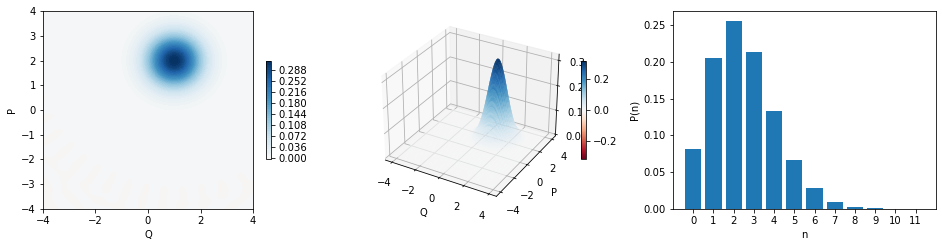

In [18]:
Wig_plot_coh=state_plot(coher,4,50,12)
print('Mean photon number is: ', expect(a1.dag()*a1,coher))

We can now see the nice Wigner function of our state along with the Poissonian photon number distribtuion of $\langle\hat{a}^\dagger \hat{a}\rangle=|\alpha|^2$.

Next, do the same thing but with a squeezed vacuum state. Then we can also apply the rotation operator after squeezing the vacuum to change the squeezing angle.

Mean photon number is:  0.12382290057728355
Expectation value of Q is  0.0
Variance of Q is  0.9968577666215033
Expectation value of P is  0.0
Variance of P is  0.25078803453306353


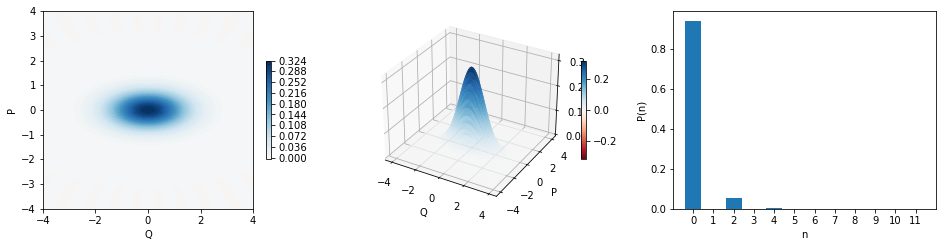

In [19]:
sqz_param=0.345 #About 3 dB of squeezing
sqz_vac=Sq(sqz_param, 0, Dim)*vac
Wig_plot_sqz=state_plot(sqz_vac,4,50,12)
print('Mean photon number is: ', expect(a1.dag()*a1,sqz_vac))
print('Expectation value of Q is ', expect(Q,sqz_vac))
print('Variance of Q is ', variance(Q,sqz_vac))
print('Expectation value of P is ', expect(P,sqz_vac))
print('Variance of P is ', variance(P,sqz_vac))

Above, we can see that the uncertainty in the $\hat{P}$ quadrature has been reduced, while the $\hat{Q}$ uncertainty is increased. Since our squeezing parameter was equivalent to 3 dB of squeezing, we see that the uncertainty doubled from the vacuum in $\hat{Q}$ and is reduced by half for $\hat{P}$. Another interesting quality of squeezed states, showcased here, is that they only contain $\textit{even}$ photon number probabilities.

Let's apply the same squeeze operator again to squeeze twice as hard, then rotate using the phase operator.

Mean photon number is:  0.5566199519267636
Variance of Q is  1.0566199519267634
Variance of P is  1.0566199519267634
Variance of (Q+P)/sqrt(2) is  1.9874490939334797
Variance of (Q-P)/sqrt(2) is  0.12579080992004604


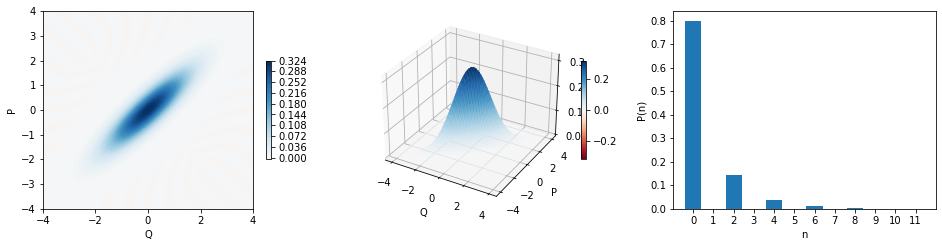

In [20]:
phase=np.pi/4
sqz_vac2=R(phase,Dim)*Sq(sqz_param, 0, Dim)*sqz_vac
Wig_plot_sqz2=state_plot(sqz_vac2,4,50,12)
print('Mean photon number is: ', expect(a1.dag()*a1,sqz_vac2))
print('Variance of Q is ', variance(Q,sqz_vac2))
print('Variance of P is ', variance(P,sqz_vac2))
print('Variance of (Q+P)/sqrt(2) is ', variance((Q+P)/np.sqrt(2),sqz_vac2))
print('Variance of (Q-P)/sqrt(2) is ', variance((Q-P)/np.sqrt(2),sqz_vac2))

The above state is squeezed twice as hard, so we should expect the minimum uncertainty to be $\tfrac{1}{4}$ of the vacuum uncertainty (so about $\tfrac{1}{8}$). However, we also rotated the state by an angle of $\tfrac{\pi}{4}$. Thus $\hat{Q}$ and $\hat{P}$ are no longer the squeezed and antisqueezed quadratures, but rather $\frac{(\hat{Q}-\hat{P})}{\sqrt{2}}$ and $\frac{(\hat{Q}+\hat{P})}{\sqrt{2}}$.

Plots of the Wigner function are helpful because they give a general idea about both quadratures simultaneous. They are also useful as they easily indicate the difference between Gaussian and non-Gaussian state (non-Gaussian pure states have negativity in phase space). It is important to note that for a statistical mixture, the Wigner function may be positive everywhere yet still by non-Gaussian. On occassion, however, it is also nice to directly plot the probability distribution of the quadratures. This can be done by integrating the Wigner function over the conjugate quadrature. 

Let's try this with some Fock states. We know that
$$|n\rangle=\frac{\pi^{-1/4}}{\sqrt{2^n n!}}\int\!dx e^{-x^2/2}H_n(x)|x\rangle_q$$
where $H_n(x)$ are the $n$-th order Hermite polynomials and $|x\rangle_q$ is an eigenstate of the $\hat{Q}$-quadrature. Let's verify this by calculating the Wigner function of a Fock state, integrating it, and comparing the resultant probability to the Hermite polynomials.

Minimum value of the Wigner function is  -0.3183098861837905


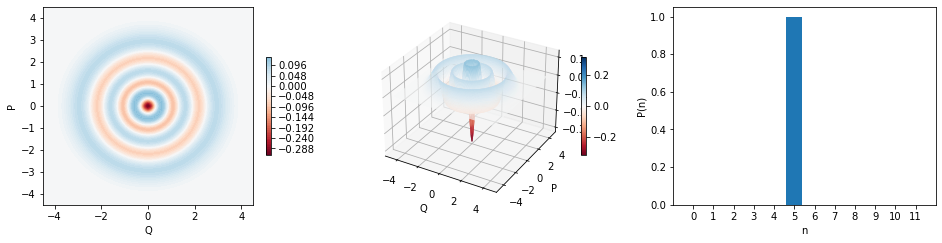

In [21]:
from scipy.integrate import simps
from scipy.special import hermite
from scipy.special import factorial as fac

five_photon=fock(Dim,5)
#increase the number of points in the plot so the integral will be more accurate
Wig_plot_fock=state_plot(five_photon,4.5,80,12) 
print('Minimum value of the Wigner function is ', np.min(Wig_plot_fock[0]))

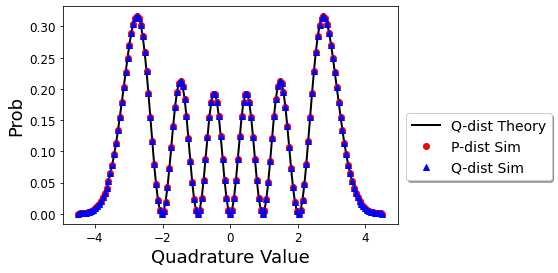

In [22]:
dx=4.5/80
xvec = np.arange(-80,81)*dx #Use same xvec as above
W=wigner(five_photon,xvec,xvec) #Wigner function as a 2D array
pdist=simps(W,xvec,dx) #integrate over the q axis to get the p distribution
qdist=simps(W.T,xvec,dx) #integrate over the p axis to get the q distribtuion

###Define the theoretical 5-photon Fock state distribution in terms of the Hermite polynomial###
theory_dist=(np.e**(-xvec**2)*(hermite(5)(xvec))**2)/(2**5*fac(5)*np.pi**(1/2))

plt.plot(xvec,theory_dist,'-k', xvec,pdist,'or',xvec,qdist,'^b', linewidth=2)
plt.legend(('Q-dist Theory','P-dist Sim','Q-dist Sim', ),
            loc=(1.025,0.2), shadow=True, fontsize=14)
plt.xlabel('Quadrature Value',fontsize=18)
plt.ylabel('Prob',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From above, we get great agreement between all of the different calculations. Note that to get the probability distribution along any generalized quadrature, it is usually easier computationally to simply rotate the state in phase-space first (with the rotation operator), and then calculate and integrate the Wigner function along the 'new' $\hat{Q}$ and $\hat{P}$ axes.

# Interactions and Detection

Next, we'll go through how to simulate basic interactions between qumodes and simulate projective measurement. To do this, let's start by simulating the Hong-Ou-Mandel effect. First, we'll need to define a beamsplitter operator along with a function for detection.

In [23]:
def BS(theta,Dim):
    a1=destroy(Dim)
    a2=destroy(Dim)
    op=((theta)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2)))
    return op.expm()
def PNR_m1(n,Dim): #pure PNR measurement on mode 1 of two modes
    proj=tensor(fock(Dim,n)*fock(Dim,n).dag(),qeye(Dim))
    return proj

The Hong-Ou-Mandel effect occurs when a single photon is input on each input of a balanced beamsplitter. Due to the quantum interference, the photons will perfectly 'bunch' in that they will both exit the beamsplitter together on the same output port. To show this, let's look at the probability to measure a single photon on one of the beamsplitter outputs as a function of beamsplitter reflectivity. When the beamsplitter is perfectly transmittive, the photons don't interact and the detector should always measure one photon. Once the beamsplitter becomes balanced with $r=t$, we expect the photons to bunch, so the detector would either see zero or two photons. Thus the probability to measure a single photon drops to zero.

To show this, we'll but a single photon in each input and apply the beamsplitter unitary,
$$\hat{B}=e^{\theta(\hat{a}_1\hat{a}^\dagger_2-\hat{a}^\dagger_1\hat{a}_2)}.$$

Then we'll plot the probability to measure a single photon on output one as a function of $\theta$.



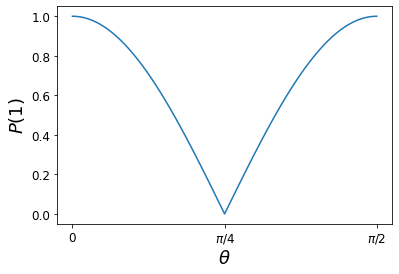

In [24]:
Dim=5
photon1=fock(Dim,1)
photon2=fock(Dim,1)
in_state=tensor(photon1,photon2) #two-mode input state
theta_vec=np.linspace(0,np.pi/2,101) #values for beamsplitter angle
single_photon_prob=[] #empty list to hold our probabilities
for i in theta_vec: #Loop through each theta value
    out_state=BS(i,Dim)*in_state #state after the beamsplitter
    prob=(PNR_m1(1,Dim)*out_state).norm() #Project the output mode 1 on a single photon and get the coefficient 
    single_photon_prob.append(prob)
plt.plot(theta_vec,single_photon_prob)
plt.xlabel(r'$\theta$',fontsize=18)
plt.ylabel(r'$P(1)$',fontsize=18)
plt.xticks([0,np.pi/4,np.pi/2],['0',r'$\pi/4$',r'$\pi/2$'],fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Photon Catalysis 

Building on the idea of the Hong-Ou-Mandel effect, let's go on to simulate Photon Catalysis, which can be thought of as a generalized Hong-Ou-Mandel effect. With this, a single photon, $|1\rangle$ is input into one port of the beamsplitter while the other port is allowed to be any quantum state, $|\psi\rangle$. Next, the user measures one output mode with a photon-counting detector to measure $k$ photons. The output state can thus be expressed as
$$|\phi\rangle={}_1\langle k|\hat{B}(\theta)|1\rangle_1|\psi\rangle_2.$$
Regardless of the initial state, $|\psi\rangle$, any particular fock-basis component of the output state may be filtered out depending on the beamsplitter parameter and post-selected detection result.

To simulate this, let's start with a single photon in mode one and a coherent state with mean photon number $|\alpha|^2=4$ in mode two, and then interfere them at a balanced beamsplitter. To leave things slightly more general, let's write everything in terms of density matrices instead of kets. This way, we can easily extent our code to mixtures as well as pure states. To do this, we can use the QuTiP function ket2dm() to turn an input ket into a density matrix, or we can immediately start from a fock state and coherent state density matrix using '\_dm' as per built-in QuTiP utilities.

Next, remember that density matrices evolve as $\rho'=\hat{U} \rho \hat{U}^\dagger$, and we can get mode two alone by performing a partial trace over mode one. Thus our output density matrix, $\sigma$, for photon catalysis will look like:  
$$\sigma = \frac{\text{Tr}_1[|k\rangle\langle k|\hat{B}\rho_{12}\hat{B}^\dagger]}{P(k)}$$
where
$$P(k)=\text{Tr}[|k\rangle\langle k|\hat{B}\rho_{12}\hat{B}^\dagger]$$
is the probability of detecting $k$ photons in mode one.


Probability to detect  3  photons in mode one is:  0.13533528323576166
Verify the output is normalized: trace of  $\rho$  is  1.0
Probability of  3  photons to now also be in mode two:  0.0


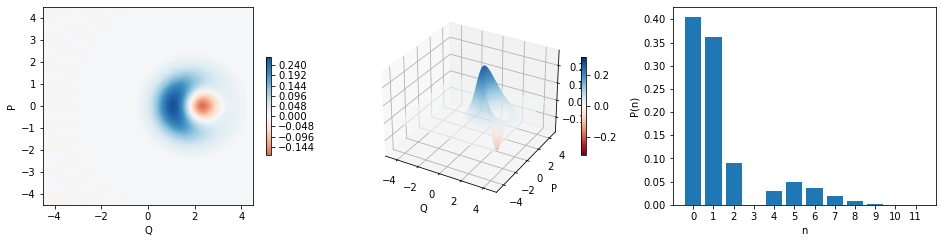

In [25]:
Dim=30
alpha=2
k=3
mode1=fock_dm(Dim,1) #single photon density matrix
mode2=coherent_dm(Dim,alpha) #coherent state density matrix
bs5050=BS(np.pi/4,Dim) #balanced beamsplitter
rho_in=tensor(mode1,mode2) #state into the beamsplitter

P_k=(PNR_m1(k,Dim)*bs5050*rho_in*bs5050.dag()).tr() #probability of measuring k photons in mode 1
rho_out=(PNR_m1(k,Dim)*bs5050*rho_in*bs5050.dag()).ptrace(1)/P_k

#NOTE: The operation .ptrace(m) takes the partial trace over every mode 
#EXCEPT m, where the numbering startes at 0.  So .ptrace(1) means you 
#keep the second mode and trace out over the first

print('Probability to detect ', k, ' photons in mode one is: ', P_k)
print('Verify the output is normalized: trace of ', r'$\rho$', ' is ', rho_out.tr())
print('Probability of ', k, ' photons to now also be in mode two: ', rho_out.diag()[3])
Wig_plot=state_plot(rho_out,4.5,80,12) 

Interestingly, we see that for the balanced beamsplitter and a 3 photon detection in mode one, it is impossible to subsequently detect 3 photons in mode two as well! It turns out that the input state can be of any form, and that it doesn't matter what photon number was detected in mode one at all. Provided one input to the beamsplitter is a single-photon and the beamsplitter is balanced, a detection of $k$ photons in mode one ensures the $k$ photon probability in mode two is exactly zero. This can also be extended to a variety of beamsplitter angles, and in fact, to larger Fock-state inputs. 

# Simulating Loss 

Loss is one of the largest sources of experimental error in any quantum optics experiment, and thus it is important to simulate. Loss degrades the purity of a state, so we must do everything with density matrices in this case (occassionally there are ways around this if all loss is commuted to the detection). Loss can be modeled by interfering a state with vacuum at a beamsplitter and tracing out over the reflected mode. Let's try this with a 5-photon Fock state and $20\%$ loss.

Minimum value of the Wigner function is  -0.02584281790869087


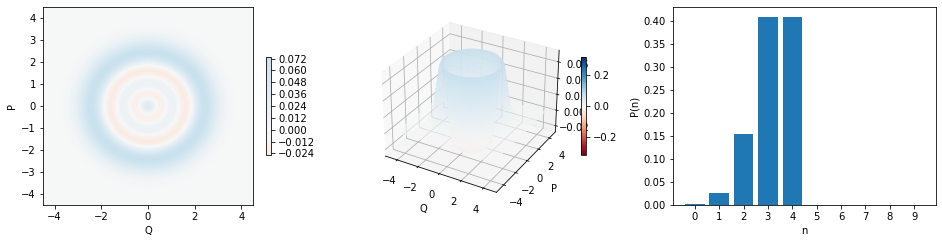

In [26]:
Dim=10
fivephotondm=fock_dm(Dim,4) #five-photon density matrix
vac=fock_dm(Dim,0) #vacuum density matrix
loss=0.2
loss_theta=np.arcsin(np.sqrt(loss)) #cos(theta)^2=loss
loss_bs=BS(loss_theta,Dim) #define the beamsplitter
bs_output=loss_bs*tensor(fivephotondm,vac)*loss_bs.dag() #two-mode state after the beamsplitter
lossy_state=(bs_output.ptrace(0))/bs_output.tr() #trace out over reflected mode and normalize

Wig_plot=state_plot(lossy_state,4.5,80,Dim) 
print('Minimum value of the Wigner function is ', np.min(Wig_plot[0]))

Already at $20%$ loss, we see that the negativity in the Wigner function has nearly vanished, dropping from $-\tfrac{1}{\pi}\approx-0.32$ to $-0.025$. Although the negativity won't entirely vanish until the loss reaches $50\%$. Similarly, the five photon component is no longer even the dominant value. This demonstrates why quantum experiments can be quite challenging - loss must be very low to see quantum effects. 

Suppose we weren't interested in getting the full quantum state, but only simulate the probability distribution. Instead of introducing the ancillary vacuum mode and needing to simulate a full two-mode system, we can instead use a detector POVM with imperfect detection efficieny to describe the loss. This is exeedingly useful when loss needs to be simulated for multi-mode systems and adding additional vacuum modes is infeasible to simulate use to the exponential scaling of the Hilbert space. 

Detector inefficiency can be exactly described by a loss channel (beamsplitter and partial trace) before a perfect detector. Similarly, one could commute all of the losses in an experiment to the detection, and then just model the imperfect detector. To do this, we will project our pure state onto a detector described by a weighted sum of Fock-basis projectors that has the information about efficiency already accounted for.

In [27]:
from scipy.special import binom #import binomial coefficient calculator

def pnr_det_eta(eta, click, n_trunc,Dim):
    #eta: detector efficiency
    #click: number of photons measured
    #n_trunc: maximum number of photons resolvable by the detector
    #Dim: hilbert space dimension
    pi_n = 0;
    vec = np.arange(click,n_trunc)
    #Build the POVM sum for a detector with quantum efficiency eta<1
    for i in vec:
          pi_n +=  binom(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(Dim,i)*fock(Dim,i).dag()
    return Qobj(pi_n)

Now that this POVM is defined, I can calculate the probability to measure any given photon number of a quantum state, $\rho$, using 
$$P(n)=\text{Tr}[\hat{\Pi}_n\rho],$$
where $\hat{\Pi}_n$ is the POVM element associated with an $n$ photon detection event. This probability is exactly the same as the probability to measure $n$ photons with a perfect detector after $\rho$ has gone through a lossy channel where the transmission of the channel is given by $\eta$. Let's check this with the five-photon Fock state and look at the probability distribution for the same $20\%$ loss ($\eta=0.8$).

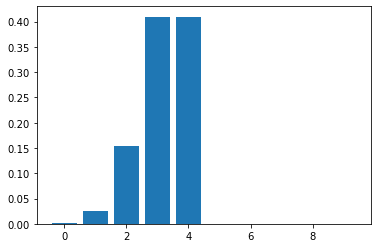

In [28]:
photon_probs=[]
eta=0.8
for n in range(Dim):
    photon_probs.append((fivephotondm*pnr_det_eta(eta,n,Dim,Dim)).tr())
plt.bar(range(Dim),photon_probs)
plt.show()

The above distribution is exactly, the same as before, but we didn't need to include the ancillary vacuum mode! However, this methods will only yield the diagonal of the density matrix as opposed to the whole state. Alternatively, since loss is a well-defined statistical process, it is possible to define a linear map to map the density matrix before loss to one after loss, but we won't get into that here. The method shown above with detector POVMs is particularly useful in two mode cases where one would like to project on a particular photon number, such as in photon catalysis, but one doesn't want to use an ancillary mode. 

The catalysis function defined below wraps everything we did with photon catalysis before into a single function, where the user inputs two states, a beamsplitter reflectivity, and the number of photons to project on with an imperfect detector.

In [29]:
def catalysis(in1,in2,refl,num_det,eta,Dim):
    #'refl' is the beamsplitter reflectivity such that 1-refl=transmittance (r^2+t^2=1 where refl=r^2)
    #first, turn the inputs into density matrices if they aren't already
    if isket(in1)==True:
        rho1=ket2dm(in1)
    else:
        rho1=in1
    if isket(in2)==True:
        rho2=ket2dm(in2)
    else:
        rho2=in2
    a1=destroy(Dim)
    a2=destroy(Dim)
    Projector = tensor(pnr_det_eta(eta, num_det, Dim,Dim),qeye(Dim)); #Detector POVM used to project mode 1
    Initial_state=tensor(rho1,rho2); #tensor product of two input density matrices
    theta=np.arccos(np.sqrt(refl)); #beamsplitter parameter
    
    BS1= ((theta)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm() #Unitary beamsplitter operator
        
    Rho=BS1*Initial_state*BS1.dag(); #evolve the density matrix through the beamsplitter
    
    P=(Rho*Projector).tr() #Find the probability to detect 'num' photons in mode 1
    print('The probability of a sucessful detection is:',P)   
    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr()) #find the normalized output state
    '''The operation .ptrace(m) takes the partial trace over every mode 
    EXCEPT m, where the numbering startes at 0.  So .ptrace(1) means you 
    keep the second mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num_det,
          '> state.')
    return Rho_filtered


First, replicate what we did before with perfect detector efficiency, single photon on one input, coherent state on the other, balanced beamsplitter, and a projection of 3 photons on output mode one. Then plot the resulting state.

Next, do the same considering $10\%$ loss on the projection detector and compare the results.

The probability of a sucessful detection is: 0.13533528323576166
BS has reflectivity 0.5  and I am detecting the | 3 > state.
Minimum value of the Wigner function without loss is  -0.17903979403201714


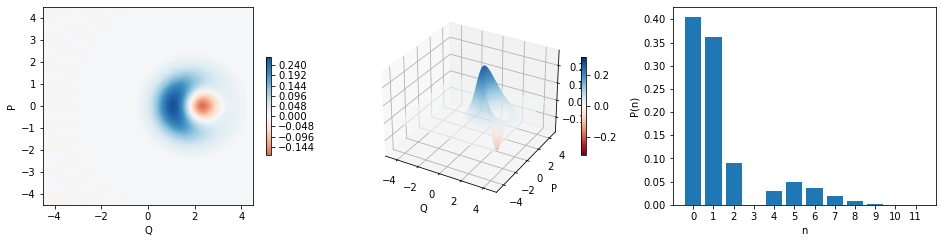

The probability of a sucessful detection is: 0.14621017260273436
BS has reflectivity 0.5  and I am detecting the | 3 > state.
Minimum value of the Wigner function with 10% loss is  -0.1224461516440973


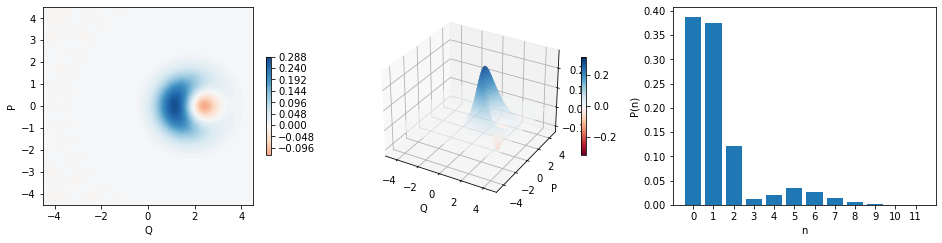

In [30]:
Dim=30
alpha=2
k=3
eta1=1
state1=catalysis(fock_dm(Dim,1),coherent_dm(Dim,alpha),0.5,k,eta1,Dim) 
Wig_plot1=state_plot(state1,4.5,80,12) 
print('Minimum value of the Wigner function without loss is ', np.min(Wig_plot1[0]))
plt.show()

eta2=0.9
state2=catalysis(fock_dm(Dim,1),coherent_dm(Dim,alpha),0.5,k,eta2,Dim) 
Wig_plot2=state_plot(state2,4.5,80,12) 
print('Minimum value of the Wigner function with 10% loss is ', np.min(Wig_plot2[0]))

We can now directly see the effects of loss for this process. The amount of Wigner negativity has decreased, but perhaps more importantly, the probability to measure 3 photons in the new output is no longer zero.

# Example: Generating Cat States 

I will now show an example using photon catalysis to make cat states. I'll first define a superposition of squeezed vacuum (SSV) state, otherwise known as a squeezed cat state, to use as a benchmark. Then, using single photons, a coherent state, and PNR detectors, I will show how repeating photon catalysis can generate the same SSV state. More details can be found in [M Eaton, R Nehra, O Pfister, NJP 21 (11), 113034 (2019)](https://iopscience.iop.org/article/10.1088/1367-2630/ab5330/pdf).

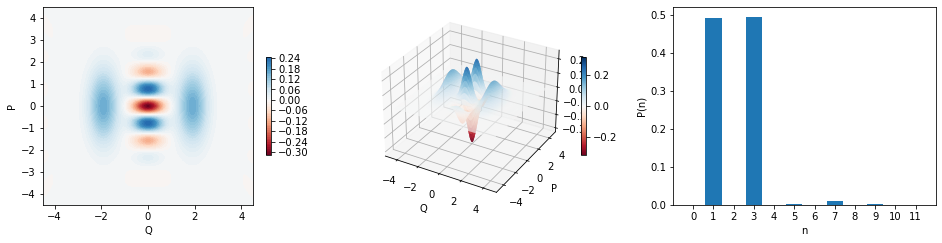

In [31]:
def SSV_minus(r,alpha,Dim):
    state = ket2dm((displace(Dim,alpha)-displace(Dim,-alpha))
                   *squeeze(Dim,r)*fock(Dim,0))
    norm_state = state/state.tr()
    return norm_state
Dim=30
ssv=SSV_minus(0.476595,1.349,Dim) #benchmark squeezed cat-state 
Wig_plot_cat=state_plot(ssv,4.5,80,12) 

The probability of a sucessful detection is: 0.07142454603455682
BS has reflectivity 0.406490404356  and I am detecting the | 5 > state.
The probability of a sucessful detection is: 0.15531158677247464
BS has reflectivity 0.240952375161  and I am detecting the | 2 > state.
The probability of a sucessful detection is: 0.1619065393887992
BS has reflectivity 0.270540418225  and I am detecting the | 1 > state.


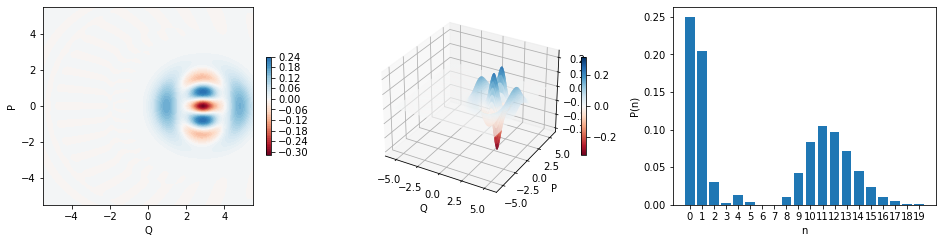

In [32]:
Dim = 30 ##Dimenstion of the Hilbert spac
eta=1 #detector efficiency -- set eta=1 for ideal case


#parameters from Table D1 of the NJP 2019 paper
refl1=0.637566**2; refl2=0.490869**2; refl3=0.520135**2;
delta=3.53709; beta=2.03846; sq=0.476595; alpha=1.349; n1=5;n2=2;n3=1;

fock1=fock_dm(Dim,1) #input fock state at each state
coher_in=coherent_dm(Dim,delta) #input coherent state

step_one=catalysis(coher_in,fock1,refl1,n1,eta,Dim) #stage one, detect n1 photons on output
step_two=catalysis(step_one,fock1,refl2,n2,eta,Dim); #stage two, detect n2 photons
step_three=catalysis(step_two,fock1,refl3,n3,eta,Dim); #stage three, detect n3 photons
 
W_step3=state_plot(step_three,5.5,80,20) 

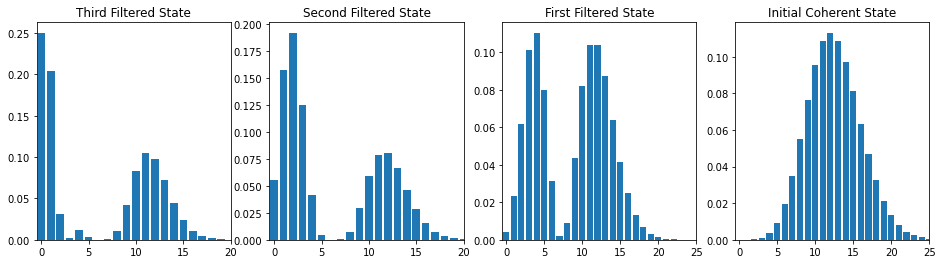

In [33]:
#plot photon number distributions
fig, axes = plt.subplots(1, 4, figsize=(16,4))
bar0 = axes[0].bar(range(Dim), step_three.diag())
lbl0 = axes[0].set_title("Third Filtered State")
lim0 = axes[0].set_xlim([-.5, 20])
bar1 = axes[1].bar(range(Dim), step_two.diag())
lbl1 = axes[1].set_title("Second Filtered State")
lim1 = axes[1].set_xlim([-.5, 20])
bar2 = axes[2].bar(range(Dim), step_one.diag())
lbl2 = axes[2].set_title("First Filtered State")
lim2 = axes[2].set_xlim([-.5, 25])
bar3 = axes[3].bar(range(Dim), ket2dm(coherent(Dim,delta)).diag())
lbl3 = axes[3].set_title("Initial Coherent State")
lim3 = axes[3].set_xlim([-.5, 25])
plt.show()

As a last step, the state must be dispalced back to the origin. Then we can calculate the fidelity of our state with our target squeezed cat state.

Fidelity with the target SSV state is:  0.9828867072962356


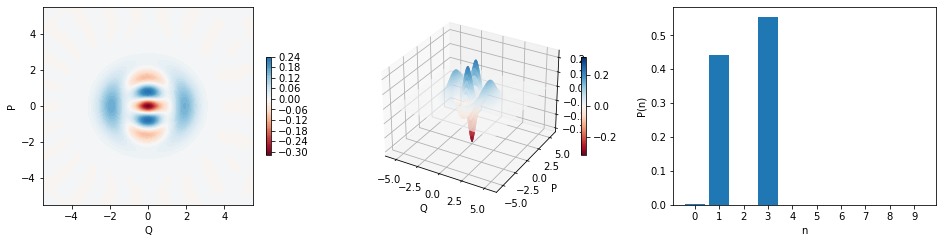

In [34]:
final_state=D(-beta,Dim)*step_three*D(-beta,Dim).dag() #displace final state back to the origin
print('Fidelity with the target SSV state is: ', fidelity(ssv,final_state)**2)
W_fin=state_plot(final_state,5.5,80,10) 